#### Updates: 
+ Successfully able to

### <font color=red> This notebook includes: </font>

    1. Baseline models for underreporting case based on simulated datasets: 
        a. Models for generating probabilities of reporting cases: (using panel data) => generate the possiblity of reporting by an individual
            + Binary Probit model to extract the probability density function 
            + Bayesian Inference Model (have been introduced much earlier) to extract the exact probabilities 
            + Bernoulli modelling 
            + Binary Poisson Model
            + Comparisons
        
        c. Models for underreporting regression: => aim to estimate the specific cases of underreporting based on a fixed reporting probability
            + Negative Binomial modelling
            + Beta- Poisson 
            + 3 models of generalized poisson distribution with different sets of parameters 
    2. Model Comparison: 
        + Actually along with every provided models I printed out the summary of efficiency of each model already. This part is just to sum up and give a concrete conclusion
    

In [1]:
#import-packages: Might be included in the requirements.txt after I complete with all tasks
import pandas as pd
import numpy as np 
from numpy import random
import math
from datetime import datetime
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline
import sys
import re
import patsy as pt
import pymc3 as pm
plt.style.use('seaborn-darkgrid')
import sympy as sp
sp.init_printing()
from sympy import symbols, solve, Eq
from sklearn.model_selection import train_test_split

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\Acer\anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Introduction: 


In purpose of selecting an optimal method for identifying the underreporting situation of COVID 19, a simulated dataset is indeed needed to apply theoritical assumptions and hypothesises before implementing on the actual raw dataset of the problem. The following of this Jupyter Notebooks focuses on presenting several ways of generating random datasets that would be valuable for future application.

This jupyter book includes baselines models such as **Poisson Binary Regression, Negative Binomial Underreporting Model, Binomial Model**

## 1. Simple Random Sampling:
A fundamental technique to provide a synthetic dataset with independent variables to apply our baseline models. Future work will consider a more applicable dataset using the importance sampling integrated with MonteCarlo Sampling, Boostrapped Sampling from the real dataset and Latin Hypecubel Sampling. For the sake of simplicity in baseline works, a simple random sampling is implemented. The details and descriptions of variables are explained in the comment lines.
+ The file *datatool.py* includes the method of SRS 

#### Current problem is that I have not account the right distribution for the probability of reporting --> pending to fix it 

In [1]:
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
from datatool import simple_gen, get_panel_data,analyse_feature_importance

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\Acer\anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df1=simple_gen(2)

dfp,X,y,X_train, X_test, y_train, y_test=get_panel_data()


In [3]:
df1

,date,actual,reported,area1,area2,area3,HighTemp,LowTemp,death
0,2020-01-01,764,237,217,2,18,25,11,0
1,2020-01-02,71,5,0,5,0,25,15,38
2,2020-01-03,50,30,5,17,8,18,10,34
3,2020-01-04,828,731,173,511,47,22,15,39
4,2020-01-05,638,126,64,13,49,29,19,36
...,...,...,...,...,...,...,...,...,...
82,2020-03-23,263,230,26,187,17,23,10,33
83,2020-03-24,796,680,24,433,223,14,10,1
84,2020-03-25,605,349,65,199,85,20,14,31
85,2020-03-26,48,24,18,5,1,18,10,20


In [5]:
dfp

,height,weight,insurance,immigrant,contacts_count,house_count,public_transport_count,worried,covid19_positive,covid19_symptoms
0,184,80,True,True,8,5,0,4,True,False
1,164,84,True,True,8,1,0,4,True,False
2,170,64,True,True,10,1,0,4,True,False
3,132,124,True,True,8,10,0,4,True,False
4,184,118,True,True,8,3,0,4,True,True
...,...,...,...,...,...,...,...,...,...,...
5106,166,66,True,True,1,2,0,4,False,False
5107,168,70,True,False,2,3,0,4,False,False
5108,182,82,True,True,3,3,0,4,False,False
5109,184,80,True,True,0,3,0,3,False,False


# 2. Poisson Regression: 

In [6]:
df1.set_index('date',inplace=True)
ds = df1.index.to_series()
df1['MONTH'] = ds.dt.month
df1['DAY_OF_WEEK'] = ds.dt.dayofweek
df1['DAY'] = ds.dt.day

 
        
    

In [7]:
mask = np.random.rand(len(df1)) < 0.8
df_train = df1[mask]
df_test = df1[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=68
Testing data set length=19


In [8]:
expr = 'reported ~ area1+area2+area3+death + DAY  + DAY_OF_WEEK + MONTH + HighTemp + LowTemp'

In [9]:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [10]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [11]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               reported   No. Observations:                   68
Model:                            GLM   Df Residuals:                       58
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1329.6
Date:                Sat, 12 Dec 2020   Deviance:                       2187.9
Time:                        21:21:29   Pearson chi2:                 1.84e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.4763      0.043    105.044      

We can see that all regression coefficients (know as the β vector in regression parlance) are statistically significant at the 95% confidence level since their p-value is < 0.05.

In [12]:
print('variance='+str(df1['reported'].var()))
print('mean='+str(df1['reported'].mean()))

variance=61707.24325046777
mean=275.735632183908


In [13]:
default_predictions = poisson_training_results.predict(X_test)
predicted_counts=default_predictions
reported_counts = y_test['reported']
real_counts=mlem
fig = plt.figure()
fig.suptitle('Default Poisson Model')
real,=plt.plot(X_test.index, mlem,'v-', label='Actual Cases')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Reported counts')
reported, = plt.plot(X_test.index, actual_counts, 'ro-', label='Predicted counts')
plt.legend(handles=[predicted, reported, real,])
plt.show()

NameError: name 'mlem' is not defined

The variance is clearly much greater than the mean. The data is grossly over-dispersed and the primary assumption of the Poisson model does not hold.

*In 1989, Prem C. Consul, in his book, Generalized Poisson Distributions: Properties and Applications, proposed a way to modify the probability distribution of the Poisson distribution so that it could handle both over dispersed and under dispersed data. This model came to be known as the GP-1 (Generalized Poisson-1) model. The GP-1 model assumes that the dependent variable y is a random variable with the following probability distribution:*
<img src="gp1.png" style="width:400px;height:350px"/>

+ α is known as the dispersion parameter and it is calculated by <img src="alpha.png" style="width:400px;height:350px"/>
+ mu is the mean count of the sample
+ k is the count number at different time t

In [ ]:
gen_poisson_gp1 = sm.GeneralizedPoisson(y_train, X_train, p=1)
gen_poisson_gp1_results = gen_poisson_gp1.fit()
print(gen_poisson_gp1_results.summary())

In [ ]:
mlem

In [ ]:
gen_poisson_gp1_predictions = gen_poisson_gp1_results.predict(X_test)
predicted_counts=gen_poisson_gp1_predictions
reported_counts = y_test['reported']
real_counts=mlem
fig = plt.figure()
fig.suptitle('GP-1 Model')
real,=plt.plot(X_test.index, mlem,'v-', label='Actual Cases')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Reported counts')
reported, = plt.plot(X_test.index, actual_counts, 'ro-', label='Predicted counts')
plt.legend(handles=[predicted, reported, real,])
plt.show()

**In 1993, Felix Famoye introduced what he referred to as the Restricted Generalized Poisson Regression Model, as a way to extend the reach of the standard Poisson model to handling over-dispersed and under-dispersed data sets. This model has come to be known as the GP-2 (Generalized Poisson-2) model.**
<img src="gp2.png" style="width:200px;height:100px"/>

In [ ]:
#Build Famoye's Restricted Generalized Poison regression model, know as GP-2
gen_poisson_gp2 = sm.GeneralizedPoisson(y_train, X_train, p=2)

#Fit the model
gen_poisson_gp2_results = gen_poisson_gp2.fit()

#print the results
print(gen_poisson_gp2_results.summary())

In [ ]:
gen_poisson_gp2_predictions = gen_poisson_gp2_results.predict(X_test)
predicted_counts=gen_poisson_gp2_predictions
real_counts=mlem
actual_counts = y_test['reported']
fig = plt.figure()
fig.suptitle('GP-2 Model Outcome')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Reported counts')
real,=plt.plot(X_test.index, mlem,'v-', label='Actual Cases')
plt.legend(handles=[predicted, actual,real,])
plt.show()


This model does not work due to the fact that 4 over 6 variables are boolean, the dataset should be modified soon

## 2. Negative Binomial Regression

In [ ]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [ ]:
print(poisson_training_results.summary())

In [ ]:
print(poisson_training_results.mu)
print("len of array:{}".format(len(poisson_training_results.mu)))

In [ ]:
import statsmodels.formula.api as smf
df_train['BB_LAMBDA'] = poisson_training_results.mu

In [ ]:
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['reported'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)

In [ ]:
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, df_train).fit()
print(aux_olsr_results.params)
aux_olsr_results.tvalues

In [ ]:
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
print(nb2_training_results.summary())

In [ ]:
nb2_predictions = nb2_training_results.get_prediction(X_test)
predictions_summary_frame = nb2_predictions.summary_frame()
print(predictions_summary_frame)

In [ ]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['reported']

fig = plt.figure()
fig.suptitle('Negative Binomial Underreporting Model')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Reported counts')
real,=plt.plot(X_test.index, mlem,'v-', label='Actual Cases')
plt.legend(handles=[predicted, actual,real,])
plt.show()

# 3. Binary Probit model: to estimate the probability of reporting
Quick reminder of binary probit definition: 
+ Binary Estimate: Guess an individual reported or unreported
+ Binomial Estimate: Guess the rate of reporting and unrepoting by an individual 
+ Binary Probit Regression model: How many people (trials) does it takes to make a person report? (**so later we can see from the distribution and apply for the time-series data**)
<img src="probit.svg"/>
    *where Pr denotes probability, and Φ is the Cumulative Distribution Function (CDF) of the standard normal distribution. The parameters β are typically estimated by maximum likelihood.*




In [27]:
import pystan
from statsmodels.discrete.discrete_model import Probit
from sklearn import preprocessing  ## for standardization 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sympy.stats import Binomial
from sympy.stats import P, E, variance, Die, Normal
from sympy import Eq, simplify

#### a. Tool for visualiztations: 

In [28]:
import numpy as np
from matplotlib import pyplot as plt
from pystan.external.pymc import plots
import seaborn as sns
import sys

if sys.version_info[0] == 3:
    def xrange(i):
        return range(i)

def vb_extract(fit):
    var_names = fit["sampler_param_names"][:-1]
    samples = np.array([x for x in fit["sampler_params"]])
    
    samples_dict = {}
    means_dict = {}
    for i in xrange(len(var_names)):
        samples_dict[var_names[i]] = samples[i,:]
        means_dict[var_names[i]] = fit["mean_pars"][i]
        
    return samples_dict, means_dict, var_names


def vb_extract_variable(fit, var_name, var_type="real", dims=None):
    if var_type == "real":
        return fit["mean_pars"][fit["sampler_param_names"].index(var_name)]
    elif var_type == "vector":
        vec = []
        for i in xrange(len(fit["sampler_param_names"])):
            if var_name in fit["sampler_param_names"][i]:
                vec.append(fit["mean_pars"][i])
        return np.array(vec)
    elif var_type == "matrix":
        if dims == None:
            raise Exception("For matrix variables, you must specify a 'dims' parameter")
        C, D = dims
        mat = []
        for i in xrange(len(fit["sampler_param_names"])):
            if var_name in fit["sampler_param_names"][i]:
                mat.append(fit["mean_pars"][i])
        mat = np.array(mat).reshape(C, D, order='F')
        return mat
    else:
        raise Exception("Unknown variable type: %s. Valid types are: real, vector and matrix" % (var_type,))


def vb_plot_variables(fit, var_names):
    samples, means, names = vb_extract(fit)

    if type(var_names) == str:
        var_names = [var_names]
    elif type(var_names) != list:
        raise Exception("Invalid argument type for var_names")

    to_plot = []
    for var in var_names:
        for i in xrange(len(fit["sampler_param_names"])):
            if var == fit["sampler_param_names"][i] or var in fit["sampler_param_names"][i]: 
                to_plot.append(fit["sampler_param_names"][i])

    for var in to_plot:
        plots.kdeplot_op(plt, samples[var])
    plt.legend(to_plot)
    plt.show()


def report(fit, prefix=''):
    for param in fit['sampler_param_names']:
        if param.startswith(prefix):
            print(param, "=", vb_extract_variable(fit, var_name=param))
            
def plot_trace(param, param_name='parameter'):
  """Plot the trace and posterior of a parameter."""
  
  # Summary statistics
  mean = np.mean(param)
  median = np.median(param)
  cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
  
  # Plotting
  plt.subplot(1,2,1)
  plt.plot(param,color="b")
  plt.xlabel('samples')
  plt.ylabel(param_name)
  plt.axhline(mean, color='r', lw=2, linestyle='--')
  plt.axhline(median, color='c', lw=2, linestyle='--')
  plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
  plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
  plt.title('Trace and Posterior Distribution for {}'.format(param_name))

  plt.subplot(1,2,2)
  plt.hist(param, 30, density=True, color="blue",); sns.kdeplot(param, shade=True,color="g")
  plt.xlabel(param_name)
  plt.ylabel('density')
  plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
  plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
  plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
  plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
  plt.gcf().tight_layout()
  plt.legend()
    
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot
    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
    title:        the text to display at the top of the matrix
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


#### b. Define likelihood functions: 

In [29]:
import numdifftools as ndt
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.optimize import minimize
#Log-Likelihood function
def _ll_ols(y, X, beta, sigma):
    mu = X.dot(beta)
    return norm(mu,sigma).logpdf(y).sum()    
#log-likelihood for negative binomial 
def neg_loglike(theta):
    mu = theta[0] + theta[1]*x
    return -1*norm(mu, theta[2]).logpdf(y).sum()

In [30]:
dfp.describe()

,height,weight,contacts_count,house_count,public_transport_count,worried
count,5111.000000,5111.000000,5111.000000,5111.000000,5111.000000,5111.000000
mean,171.915085,83.771082,7.545881,2.998630,0.264919,3.646644
std,10.986410,23.160159,6.538236,1.673495,1.390441,0.702782
min,110.000000,44.000000,0.000000,1.000000,0.000000,1.000000
25%,164.000000,68.000000,3.000000,2.000000,0.000000,3.000000
50%,172.000000,80.000000,5.000000,3.000000,0.000000,4.000000
75%,180.000000,94.000000,10.000000,4.000000,0.000000,4.000000
max,238.000000,180.000000,21.000000,11.000000,15.000000,5.000000


In [31]:
m=dfp.loc[dfp['covid19_positive']==True]
m

,height,weight,insurance,immigrant,contacts_count,house_count,public_transport_count,worried,covid19_positive,covid19_symptoms
0,184,80,True,True,8,5,0,4,True,False
1,164,84,True,True,8,1,0,4,True,False
2,170,64,True,True,10,1,0,4,True,False
3,132,124,True,True,8,10,0,4,True,False
4,184,118,True,True,8,3,0,4,True,True
...,...,...,...,...,...,...,...,...,...,...
1865,178,106,True,True,3,3,0,4,True,False
1866,196,90,True,True,2,2,0,3,True,False
1867,192,84,True,True,20,5,0,4,True,False
1868,176,78,True,True,4,3,0,4,True,False


The simulated data indicates that there are 1870 cases of covid 19 (unreported and reported) => λ = 1870

The simulated data indicates that there are 944 cases of covid 19 (unreported and reported) => y = 937

### c. Parameter Estimation: 

+ It is hard to estimate the probability of underreporting from a list of occurances (number of infections in the time-series data). The possibility of reporting by a patient is assumed to be susceptible to their conditions and other utilities (if their health is too severe they might have higher chance of reporting and if reporting rewards them money (utility), they will consider to visit a clinic).
+ When underreporting issue happens, some actual behavioral incidences are not reported. The econometrician only observes R, when a behavior occurs (Yit = 1 - with Y is the actual incident), we model the respondent's decision on whether or not to report as in a binary probit setting as follow:
<img src="report.png"/>

In [32]:
X_train

array([[146, 56, False, ..., 0, 4, False],
       [192, 100, True, ..., 0, 4, False],
       [168, 68, True, ..., 0, 4, False],
       ...,
       [166, 80, True, ..., 0, 3, False],
       [178, 52, False, ..., 0, 4, False],
       [170, 68, True, ..., 0, 4, False]], dtype=object)

In [33]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
X_train = sm.add_constant(X_train)

model = Probit(y_train,X_train.astype('float'))
probit_model = model.fit(maxiter=1000)
probit_margeff = probit_model.get_margeff()
print('Parameters: ', probit_model.params)
print('Marginal effects: ')
print(probit_margeff.summary())
print(probit_model.summary())


Optimization terminated successfully.
         Current function value: 0.532520
         Iterations 6
Parameters:  const   -0.298083
x1      -0.015384
x2       0.007185
x3       0.154459
x4       0.497611
x5       0.015168
x6       0.070935
x7      -0.000589
x8       0.237831
x9       1.849891
dtype: float64
Marginal effects: 
       Probit Marginal Effects       
Dep. Variable:       covid19_positive
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0046      0.001     -6.693      0.000      -0.006      -0.003
x2             0.0022      0.000      6.536      0.000       0.002       0.003
x3             0.0465      0.023      2.007      0.045       0.001       0.092
x4             0.1498      0.026      5.815      0.000       0.099       0.200
x5             0.0046      0.001      4.174  

=> **The R-Square is pretty low (0.00166) stating this model is not really reliable**

In [34]:
probit_model.conf_int(alpha=0.05)

,0,1
const,-1.109972,0.513807
x1,-0.019963,-0.010805
x2,0.004995,0.009376
x3,0.003424,0.305493
x4,0.328164,0.667059
x5,0.008002,0.022334
x6,0.042232,0.099638
x7,-0.034394,0.033217
x8,0.169326,0.306337
x9,1.667161,2.032620


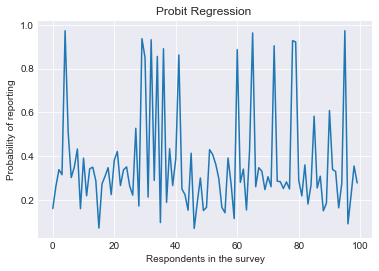

In [35]:
T=probit_model.predict()

plt.title("Probit Regression ")
plt.xlabel('Respondents in the survey')
plt.ylabel('Probability of reporting')
plt.plot(T[0:100])
plt.show()

In [36]:
T.mean()

0.36548801301497486

In [37]:
T=pd.DataFrame(T)

In [38]:
T=T.rename(columns={0:'prob'})

In [39]:
T.reset_index(inplace=True)


In [40]:
T=T.rename(columns={'index':'respondent'})

In [41]:
T

,respondent,prob
0,0,0.161605
1,1,0.262286
2,2,0.338768
3,3,0.315720
4,4,0.972060
...,...,...
3623,3623,0.029531
3624,3624,0.509526
3625,3625,0.225310
3626,3626,0.197844


<Figure size 2880x3600 with 0 Axes>

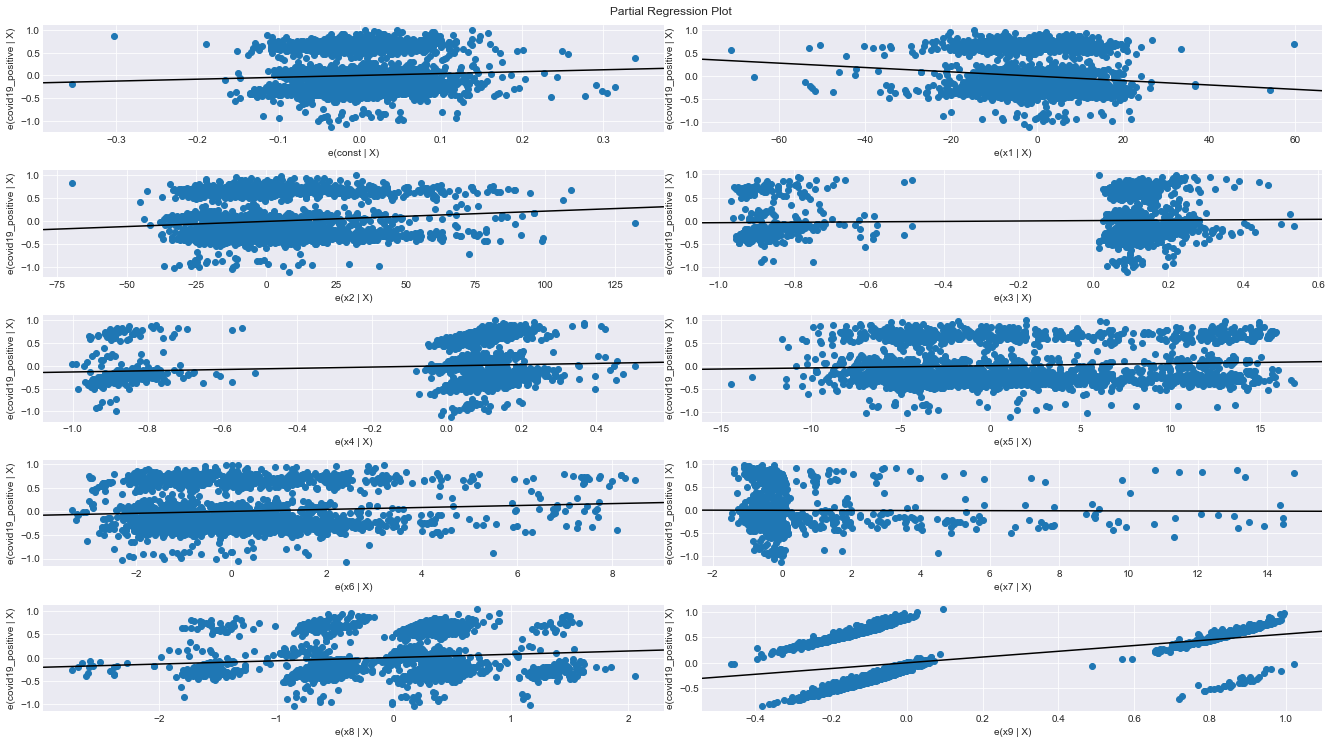

In [42]:
plt.figure(figsize=(40,50))

fig = sm.graphics.plot_partregress_grid(probit_model)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.tight_layout()

The vertical axis denotes the possibility of an individual reporting their conditions and the horizontal axis represents respective variables affecting their decisions. And it can be inferred that this model is not good enough since most of above charts displayed Zero Trend of correlation

In [ ]:
import numpy as np
from numpy import exp
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import factorial
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
from statsmodels.api import Poisson
from scipy import stats
from scipy.stats import norm
from statsmodels.iolib.summary2 import summary_col

In [ ]:
poisson_pmf = lambda y, μ: μ**y / factorial(y) * exp(-μ)
β = random.rand(5111)

y_values = range(1,100)

fig, ax = plt.subplots(figsize=(12, 8))
zx=[np.array(dfp['height']),
   np.array(dfp['weight']),
   np.array(dfp['contacts_count']),
   np.array(dfp['public_transport_count']),
   np.array(dfp['house_count'])]
for q in zx:
    μ = exp(q @ β)
    distribution = []
    for y_i in y_values:
        distribution.append(poisson_pmf(y_i, μ))
    ax.plot(y_values,
            distribution,
            label=f'$\mu_i$={μ:.1}',
            marker='o',
            markersize=8,
            alpha=0.5)

ax.grid()
ax.legend()
ax.set_xlabel('$y \mid x_i$')
ax.set_ylabel(r'$f(y \mid x_i; \beta )$')
ax.axis(xmin=0, ymin=0)
plt.show()

In [ ]:
def plot_joint_poisson(μ=7, y_n=20):
    yi_values = np.arange(0, y_n, 1)

    # Create coordinate points of X and Y
    X, Y = np.meshgrid(yi_values, yi_values)

    # Multiply distributions together
    Z = poisson_pmf(X, μ) * poisson_pmf(Y, μ)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z.T, cmap='terrain', alpha=0.6)
    ax.scatter(X, Y, Z.T, color='black', alpha=0.5, linewidths=1)
    ax.set(xlabel='$y_1$', ylabel='$y_2$')
    ax.set_zlabel('$f(y_1, y_2)$', labelpad=10)
    plt.show()

plot_joint_poisson(μ=40, y_n=20)
fig.savefig('temp.png', transparent=True)

In [ ]:
poisson_mod = sm.Poisson(y_train,X_train.astype(float))
poisson_res = poisson_mod.fit(method="newton")
print(poisson_res.summary())


# testing the model
predVals = poisson_res.predict()

plt.plot(range(len(y_train)), T, 'r*-', range(len(y_train)), predVals, 'bo-')
plt.title('Poisson vs Binary Probit')
plt.legend(['Probit', 'Poisson'])
plt.show()

=> Along with the given sample of covid19 report survey, it is inferred from the above chart that Poisson has the higher rate of reporting. To estimate the 'good' between the two models, Binary Probit has higher tendency of making right estimates compared to Poisson in term of R2-squared(0.0015 and 0.0005)  and log-likelihood (-2500 and -3000) 

### Limitation: 
+ Not accounting for delay period and doubling time rate
+ Not accounting for the false of testing 
+ The model is not realiable enough for generalization 

### What's next? 
+ Continue with my old models (Bayesian Inference - upgraded and SEIR with this dataset)
+ Compare their performances with these baseline models in term of MAP, log-likelihood and R-squared (SEIR do not have R square so I might need to make my own pseudo Rsquared)
+ Attempt 1 more baseline model (beta-Poisson) since beta distribution does not concern of overdispersion problem
+ Finally apply on the real dataset with (again) some synthetic (madeup) variables
+ Possibilities model need to reviewed

In [11]:
df1['newreported']=df1['reported']*1.365

In [12]:
df1['newreported']=df1.newreported.astype('int')

In [20]:
df1.set_index(df1['date'],inplace=True)

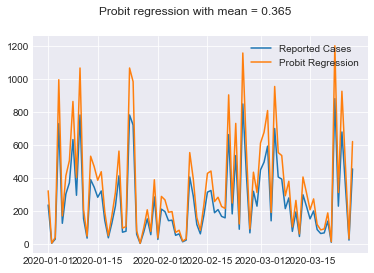

In [25]:
import matplotlib.pyplot as plt
fig=plt.figure()
fig.suptitle('Probit regression with mean = 0.365')

w,=plt.plot(df1.index,df1['reported'],label='Reported Cases')
r,=plt.plot(df1.index,df1['newreported'],label='Probit Regression')
plt.legend(handles=[w,r,])
plt.show()


